In [26]:
%load_ext autoreload
%autoreload 2

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

astract_model.py, con_idxs =  Field(name=None,type=None,default=<dataclasses._MISSING_TYPE object at 0x000002197A975AC0>,default_factory=<class 'list'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=None)
Running Yen model


# Download census-income dataset

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [5]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [7]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

con_idxs = [i for i, f in enumerate(features) if f not in categorical_columns]

# Network parameters

In [9]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       con_idxs = con_idxs,
                       con_emb_dim = 2,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


In [10]:
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

max_epochs = 7700 if not os.getenv("CI", False) else 2
auc = []
acc = []
base_auc = 0.9231660389507519
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0
for con_dim in range(44, 45):
    clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=2,
                       con_idxs = con_idxs,
                       con_emb_dim = con_dim,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

    clf.fit(
                            X_train=X_train, y_train=y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            eval_name=['train', 'valid'],
                            eval_metric=['accuracy'],
                            max_epochs=max_epochs , patience=20,
                            batch_size=1024, virtual_batch_size=128,
                            num_workers=0,
                            weights=1,
                            drop_last=False
                        )

    preds_class = clf.predict(X_test)
    preds = clf.predict_proba(X_test)
    test_acc = accuracy_score(y_test, preds_class)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    print("acc:", test_acc, con_dim)
    print("auc:", test_auc, con_dim)
    if test_auc>base_auc:
        print("BEAT AUC")
        beat_auc = 1
    if test_acc>base_acc:
        print("BEAT ACC")
        beat_acc = 1
    auc.append(test_auc)
    acc.append(test_acc)

Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 0.65183 | train_accuracy: 0.624   | valid_accuracy: 0.62838 |  0:00:06s
epoch 1  | loss: 0.51733 | train_accuracy: 0.60371 | valid_accuracy: 0.59174 |  0:00:12s
epoch 2  | loss: 0.46993 | train_accuracy: 0.62753 | valid_accuracy: 0.62248 |  0:00:18s
epoch 3  | loss: 0.44229 | train_accuracy: 0.70624 | valid_accuracy: 0.70817 |  0:00:25s
epoch 4  | loss: 0.40965 | train_accuracy: 0.71153 | valid_accuracy: 0.70785 |  0:00:31s


KeyboardInterrupt: 

In [13]:
# DONT TOUCH
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

max_epochs = 7700 if not os.getenv("CI", False) else 2
auc = []
acc = []
base_auc = 0.9231660389507519
base_acc = 0.8677685950413223
beat_auc = 0
beat_acc = 0
for con_dim in range(44, 45):
    clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=3,
                       con_idxs = con_idxs,
                       con_emb_dim = con_dim,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

    clf.fit(
                            X_train=X_train, y_train=y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            eval_name=['train', 'valid'],
                            eval_metric=['auc'],
                            max_epochs=max_epochs , patience=20,
                            batch_size=1024, virtual_batch_size=128,
                            num_workers=0,
                            weights=1,
                            drop_last=False
                        )

    preds_class = clf.predict(X_test)
    preds = clf.predict_proba(X_test)
    test_acc = accuracy_score(y_test, preds_class)
    test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    print("acc:", test_acc, con_dim)
    print("auc:", test_auc, con_dim)
    if test_auc>base_auc:
        print("BEAT AUC")
        beat_auc = 1
    if test_acc>base_acc:
        print("BEAT ACC")
        beat_acc = 1
    auc.append(test_auc)
    acc.append(test_acc)

Device used : cpu
In abstract_model.py, _set_network, con_idxs =  [2]
Con idxs =  [2]
Cat_idxs= [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Con_idxs= [2]
Input dim = 14
Length of embedding_dim = 14
epoch 0  | loss: 0.6455  | train_auc: 0.68439 | valid_auc: 0.66401 |  0:00:06s
epoch 1  | loss: 0.51216 | train_auc: 0.80597 | valid_auc: 0.81523 |  0:00:12s
epoch 2  | loss: 0.47769 | train_auc: 0.84526 | valid_auc: 0.8515  |  0:00:19s
epoch 3  | loss: 0.44724 | train_auc: 0.85639 | valid_auc: 0.85893 |  0:00:25s
epoch 4  | loss: 0.42559 | train_auc: 0.88103 | valid_auc: 0.88313 |  0:00:32s
epoch 5  | loss: 0.4142  | train_auc: 0.89398 | valid_auc: 0.89413 |  0:00:39s
epoch 6  | loss: 0.40087 | train_auc: 0.90327 | valid_auc: 0.9016  |  0:00:45s
epoch 7  | loss: 0.38354 | train_auc: 0.9055  | valid_auc: 0.90654 |  0:00:52s
epoch 8  | loss: 0.37405 | train_auc: 0.90923 | valid_auc: 0.90759 |  0:00:58s
epoch 9  | loss: 0.36619 | train_auc: 0.91054 | valid_auc: 0.90923 |  0:01:04s
epoch 10 | l

AUC SCORE SUMMARY
[0.922929431785081]
Different in percentage
[-0.02366072]


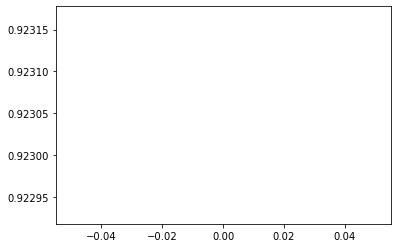

In [12]:
print("AUC SCORE SUMMARY")
print(auc)
print("Different in percentage")
print((np.array(auc) - base_auc)*100)
base_auc_plot = [base_auc]*len(auc)
plt.plot(auc)
plt.plot(base_auc_plot)

ACCURACY SCORE SUMMARY
[0.8108356290174472, 0.8276706458524641, 0.852157943067034, 0.8001224364860728, 0.8126721763085399, 0.8292011019283747, 0.8331802877257423, 0.8322620140801958, 0.8273645546372819, 0.8258340985613712, 0.8135904499540864, 0.8062442607897153, 0.8276706458524641, 0.8056320783593511, 0.8386899295990206, 0.8279767370676462, 0.8386899295990206, 0.8264462809917356, 0.8255280073461891, 0.8086929905111724, 0.8389960208142027, 0.8313437404346495, 0.8169574533210897, 0.8276706458524641, 0.8276706458524641, 0.8093051729415366, 0.8093051729415366, 0.8261401897765535, 0.8288950107131925, 0.8334863789409244, 0.8206305479032752, 0.8359351086623814, 0.8160391796755433, 0.8276706458524641, 0.8322620140801958, 0.8053259871441689, 0.830119375573921, 0.8285889194980104, 0.820018365472911, 0.8319559228650137, 0.7998163452708907, 0.8285889194980104, 0.8138965411692685, 0.8194061830425466, 0.7992041628405264, 0.8230792776247322, 0.8359351086623814, 0.7753290480563207, 0.7655341291704928,

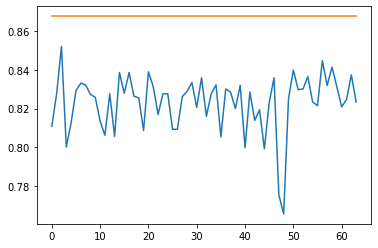

In [17]:
print("ACCURACY SCORE SUMMARY")
print(acc)
print("DIFFERENT IN PERCENTAGE")
print((np.array(acc) - base_acc)*100)
base_acc_plot = [base_acc]*len(acc)
plt.plot(acc)
plt.plot(base_acc_plot)

In [ ]:
y = pd.DataFrame(np.concatenate((y_train, y_valid, y_test)))
y.value_counts()


In [39]:
len(X_train)+len(X_valid)+len(X_test)

32560

# Training

In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [10]:
#### Customized train, valid, test
X_train = np.array(pd.read_csv('X_train.csv'))
y_train = np.array(pd.read_csv('y_train.csv')).ravel()

X_valid = np.array(pd.read_csv('X_valid.csv'))
y_valid = np.array(pd.read_csv('y_valid.csv')).ravel()

X_test = np.array(pd.read_csv('X_test.csv'))
y_test = np.array(pd.read_csv('y_test.csv')).ravel()

In [11]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [13]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=4096, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
) 

epoch 0  | loss: 0.32823 | train_auc: 0.93286 | valid_auc: 0.92837 |  0:00:04s
epoch 1  | loss: 0.32599 | train_auc: 0.9327  | valid_auc: 0.92954 |  0:00:08s
epoch 2  | loss: 0.32444 | train_auc: 0.93306 | valid_auc: 0.9298  |  0:00:12s
epoch 3  | loss: 0.31912 | train_auc: 0.93299 | valid_auc: 0.92973 |  0:00:16s
epoch 4  | loss: 0.31606 | train_auc: 0.93426 | valid_auc: 0.92868 |  0:00:20s
epoch 5  | loss: 0.322   | train_auc: 0.93397 | valid_auc: 0.92922 |  0:00:25s
epoch 6  | loss: 0.31617 | train_auc: 0.93522 | valid_auc: 0.93058 |  0:00:29s
epoch 7  | loss: 0.31477 | train_auc: 0.93498 | valid_auc: 0.93026 |  0:00:32s
epoch 8  | loss: 0.32281 | train_auc: 0.93568 | valid_auc: 0.93154 |  0:00:37s
epoch 9  | loss: 0.31456 | train_auc: 0.93602 | valid_auc: 0.93127 |  0:00:41s
epoch 10 | loss: 0.31667 | train_auc: 0.93511 | valid_auc: 0.92951 |  0:00:45s
epoch 11 | loss: 0.31061 | train_auc: 0.93601 | valid_auc: 0.9301  |  0:00:48s
epoch 12 | loss: 0.32051 | train_auc: 0.93697 | vali

In [16]:
input_dim = 5
cat_idxs = [0,1,4]
con_idxs = [2,3]
cat_dims = [10, 11, 14]
cat_emb_dim = [20, 21, 24]
con_emb_dim = [22, 23]

embedding_dim_info = []
for idx in range(input_dim):
    if idx in cat_idxs:
        embedding_dim_info.append((cat_dims[cat_idxs.index(idx)], cat_emb_dim[cat_idxs.index(idx)]))
    if idx in con_idxs:
        embedding_dim_info.append((1, con_emb_dim[con_idxs.index(idx)]))
embedding_dim_info

[(10, 20), (11, 21), (1, 22), (1, 23), (14, 24)]

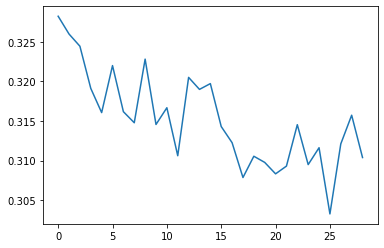

In [14]:
# plot losses
plt.plot(clf.history['loss'])

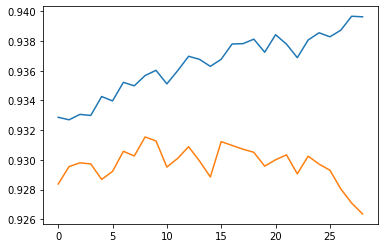

In [15]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

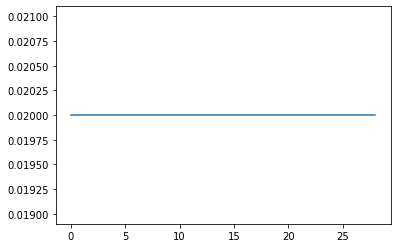

In [16]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [17]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9315416259133538
FINAL TEST SCORE FOR census-income : 0.9302749855633856


In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [ ]:
clf.predict(X_test)

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

In [ ]:
assert(test_auc == loaded_test_auc)

In [ ]:
loaded_clf.predict(X_test)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [29]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-logloss:0.63523


C:\Users\root\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-logloss:0.37927
[20]	validation_0-logloss:0.31122
[30]	validation_0-logloss:0.28684
[40]	validation_0-logloss:0.27723
[50]	validation_0-logloss:0.27253
[60]	validation_0-logloss:0.26951
[70]	validation_0-logloss:0.26908
[80]	validation_0-logloss:0.26752
[90]	validation_0-logloss:0.26729
[100]	validation_0-logloss:0.26748
[110]	validation_0-logloss:0.26783
[120]	validation_0-logloss:0.26779
[130]	validation_0-logloss:0.26815
[140]	validation_0-logloss:0.26878
[141]	validation_0-logloss:0.26909


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=8, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [30]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9336413537984218
0.9244487257452103


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
